# 0. Data Backup from InfluxDB

Imports

In [2]:
from influxdb_client_3 import InfluxDBClient3
import pandas as pd  
import pyarrow.parquet as pq
from pathlib import Path
import argparse
import math
from dataclasses import dataclass 
from typing import Optional, Dict, List, Tuple 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In this part we perform the Data Backup from influxDB. As a result, sparced dataset with raw data stored in folder 'influxDB Backup' in root folder of this repository. File format: parquet. 


In [12]:
LIMIT = 1_000_000

client = InfluxDBClient3(
    token="apiv3_9EL5Mq-kpLIFd1y3dc9ow0JWWnGPMLM9h6lcFQxQt02FZ-SZis7eJYmj27-E8EKlA_3MTUGa_QBd0holy94oEQ",
    host="http://10.65.1.77:10102",
    database="spp1-main"
)

TABLE_NAME = "saw"
OUTPUT_FILE = "influxDB Backup/saw.backup.parquet"

offset = 0
all_frames = [] # List to store each chunk in memory

print(f"Starting export of '{TABLE_NAME}'...")

while True:
    print(f"Fetching rows {offset} to {offset + LIMIT}...", end="\r")

    # Order by time is critical to ensure pages don't shuffle or overlap
    query = f"""
        SELECT * FROM "{TABLE_NAME}" 
        ORDER BY time ASC
        LIMIT {LIMIT} OFFSET {offset}
    """

    try:
        # Fetch the chunk
        df_chunk = client.query(query=query, mode="pandas")

        # If chunk is empty, we are done
        if df_chunk.empty:
            print(f"\nNo more data found after offset {offset}.")
            break
        
        # Append to our in-memory list
        all_frames.append(df_chunk)

        # Check if this was the last page (less rows than limit)
        if len(df_chunk) < LIMIT:
            print(f"\nReached end of dataset at offset {offset + len(df_chunk)}.")
            break

        # Prepare for next iteration
        offset += LIMIT

    except Exception as e:
        print(f"\nCRITICAL ERROR at offset {offset}: {e}")
        # Depending on importance, you might want to 'break' or 'raise' here
        break

# --- Final Consolidation ---
if all_frames:
    print("Concatenating data...")
    final_df = pd.concat(all_frames, ignore_index=True)

    print(f"Saving {len(final_df)} rows to {OUTPUT_FILE}...")
    final_df.to_parquet(OUTPUT_FILE, index=False)
    print("Export successful.")
else:
    print("No data was retrieved.")

Starting export of 'saw'...
Fetching rows 0 to 1000000...
CRITICAL ERROR at offset 0: Error while executing query: Flight returned unavailable error, with message: failed to connect to all addresses; last error: UNKNOWN: ipv4:10.65.1.77:10102: tcp handshaker shutdown. gRPC client debug context: UNKNOWN:Error received from peer  {grpc_message:"failed to connect to all addresses; last error: UNKNOWN: ipv4:10.65.1.77:10102: tcp handshaker shutdown", grpc_status:14, created_time:"2026-01-04T13:03:48.451546+01:00"}. Client context: IOError: Server never sent a data message. Detail: Internal
No data was retrieved.


Parquet to csv

In [ ]:
in_path = Path("influxDB Backup/saw.backup.parquet")
out_path = in_path.with_suffix(".csv")

df = pq.read_table(in_path).to_pandas()
df.to_csv(out_path, index=False)

print("Saved to:", out_path.resolve())
print("Exists:", out_path.exists(), "Size:", out_path.stat().st_size if out_path.exists() else None)


Saved to: /Users/vvsmbk/Desktop/all/3 semester classes/Smart Production and Prototyping/Practical Part/gitProject/projectRaphael/influxDB Backup/saw.backup.csv
Exists: True Size: 7143765


"Compression" of the raw csv file: after that step, all the waterflow presented data reorganized in wide format

In [21]:
df = pd.read_csv("influxDB Backup/saw.backup.csv")

df["time"] = pd.to_datetime(df["time"])
df["time_1s"] = df["time"].dt.floor("s")   # .dt.round("s") for rounding

value_cols = [c for c in df.columns if c not in ("time", "time_1s")]

out = (
    df.sort_values("time")
      .groupby("time_1s")[value_cols]
      .last()                      # last not-NaN for each column
      .reset_index()
      .rename(columns={"time_1s": "time"})
)

out.to_csv("influxDB Backup/saw_wide.csv", index=False)


# 1. Data understanding
In that phase data from the dataset is described. 

1.1. Data structure + Missing values review + Numeric & categorical summaries

In [27]:
import pandas as pd

df = pd.read_csv("influxDB Backup/saw_wide.csv")  # or pd.read_parquet("influxDB Backup/saw.backup.parquet")

# --- Data structure overview ---
rows, cols = df.shape
mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
dup_cnt = int(df.duplicated().sum())
dup_pct = (dup_cnt / rows * 100) if rows else 0.0

print("=== DATASET OVERVIEW ===")
print(f"Rows: {rows}")
print(f"Columns: {cols}")
print(f"Memory (MB): {mem_mb:.2f}")
print(f"Duplicate rows: {dup_cnt} ({dup_pct:.2f}%)")

overview = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "null": df.isna().sum(),
    "null_percentage": (df.isna().mean() * 100).round(2),
    "unique_not_null": df.nunique(dropna=True),
}).sort_values(["null_percentage", "unique_not_null"], ascending=[False, False])

print("\n=== COLUMNS OVERVIEW (sorted by missing %) ===")
print(overview.to_string())

# --- Missing values report ---
missing_only = overview[overview["null"] > 0][["null", "null_percentage"]].copy()

print("\n=== MISSING VALUES REPORT ===")
if missing_only.empty:
    print("No missing values found.")
else:
    print(missing_only.to_string())

# --- Numeric & categorical summaries ---
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\n=== NUMERIC SUMMARY ===")
if not numeric_cols:
    print("No numeric columns found.")
else:
    num_summary = df[numeric_cols].describe().T
    num_summary["missing"] = df[numeric_cols].isna().sum()
    num_summary["missing_pct"] = (df[numeric_cols].isna().mean() * 100).round(2)
    print(num_summary.to_string())

print("\n=== CATEGORICAL SUMMARY (top values) ===")
if not categorical_cols:
    print("No categorical columns found.")
else:
    for col in categorical_cols:
        print(f"\n-- {col} --")
        s = df[col]
        print(f"dtype: {s.dtype}")
        print(f"missing: {int(s.isna().sum())} ({(s.isna().mean()*100):.2f}%)")
        print(f"unique (non-null): {int(s.nunique(dropna=True))}")
        top = s.value_counts(dropna=True).head(10)
        if top.empty:
            print("No non-null values.")
        else:
            print("Top 10 values:")
            print(top.to_string())


=== DATASET OVERVIEW ===
Rows: 20738
Columns: 8
Memory (MB): 3.00
Duplicate rows: 0 (0.00%)

=== COLUMNS OVERVIEW (sorted by missing %) ===
                      dtype  non_null  null  null_percentage  unique_not_null
machineRunning       object     17991  2747            13.25                2
feedRateActual      float64     18485  2253            10.86               16
bandVelocityActual  float64     18654  2084            10.05               22
microphoneRMS       float64     20705    33             0.16            20698
vibrationRMS        float64     20705    33             0.16            20654
currentRMS          float64     20707    31             0.15            20697
temperatureRMS      float64     20708    30             0.14            18173
time                 object     20738     0             0.00            20738

=== MISSING VALUES REPORT ===
                    null  null_percentage
machineRunning      2747            13.25
feedRateActual      2253            10.86
b

1.2. Correlations with currentRMS + Heatmap

=== CORRELATION MATRIX (Spearman) ===
                    bandVelocityActual  currentRMS  feedRateActual  microphoneRMS  temperatureRMS  vibrationRMS
bandVelocityActual            1.000000    0.702108        0.980992       0.680166       -0.424205      0.680865
currentRMS                    0.702108    1.000000        0.698748       0.474267       -0.213580      0.474633
feedRateActual                0.980992    0.698748        1.000000       0.677071       -0.418530      0.680815
microphoneRMS                 0.680166    0.474267        0.677071       1.000000       -0.692241      0.847683
temperatureRMS               -0.424205   -0.213580       -0.418530      -0.692241        1.000000     -0.730882
vibrationRMS                  0.680865    0.474633        0.680815       0.847683       -0.730882      1.000000


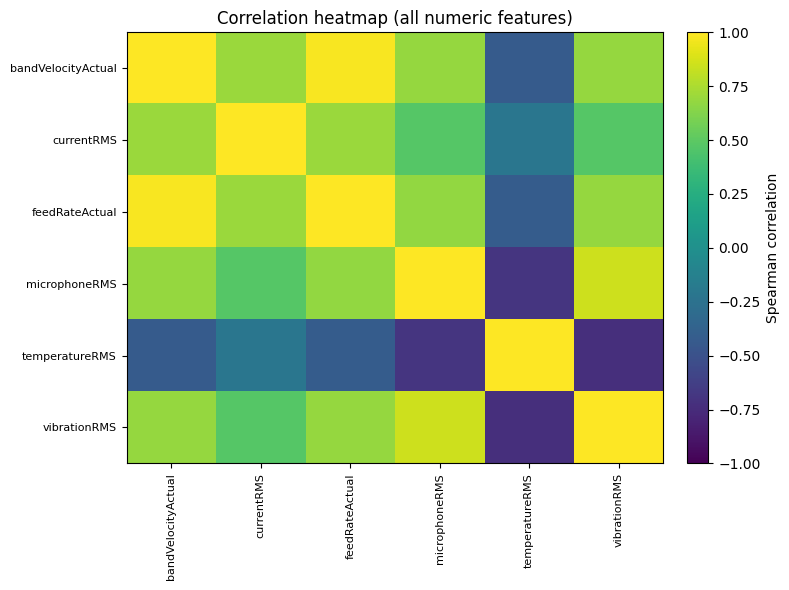

In [ ]:
# numeric columns only
num_df = df.select_dtypes(include=["number"]).copy()

# correlation matrix (choose: "pearson" or "spearman")
corr = num_df.corr(method="spearman")

print("=== CORRELATION MATRIX (Spearman) ===")
print(corr.to_string())

# heatmap (all vs all)
cols = corr.columns.tolist()
data = corr.values

plt.figure(figsize=(max(8, len(cols) * 0.5), max(6, len(cols) * 0.5)))
im = plt.imshow(data, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Spearman correlation")

plt.xticks(np.arange(len(cols)), cols, rotation=90, fontsize=8)
plt.yticks(np.arange(len(cols)), cols, fontsize=8)

plt.title("Correlation heatmap (all numeric features)")
plt.tight_layout()
plt.show()

1.3. Target relationships + simple hypothesis tests

In [33]:
target = "currentRMS"

# --- split columns ---
numeric_cols = df.select_dtypes(include=["number"]).columns.drop(target, errors="ignore")
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

print("=== TARGET RELATIONSHIPS: currentRMS ===")

# -------------------------------------------------
# Numeric features vs target (Spearman correlation)
# -------------------------------------------------
print("\n--- Numeric features (Spearman correlation) ---")

num_results = []

for col in numeric_cols:
    x = pd.to_numeric(df[col], errors="coerce")
    y = pd.to_numeric(df[target], errors="coerce")
    mask = x.notna() & y.notna()

    if mask.sum() < 30:
        continue

    corr, p = stats.spearmanr(x[mask], y[mask])
    num_results.append((col, corr, p, mask.sum()))

num_results = sorted(num_results, key=lambda x: abs(x[1]), reverse=True)

for col, corr, p, n in num_results:
    print(f"{col:25s} | corr={corr: .3f} | p-value={p:.2e} | n={n}")


=== TARGET RELATIONSHIPS: currentRMS ===

--- Numeric features (Spearman correlation) ---
bandVelocityActual        | corr= 0.702 | p-value=0.00e+00 | n=18628
feedRateActual            | corr= 0.699 | p-value=0.00e+00 | n=18458
vibrationRMS              | corr= 0.475 | p-value=0.00e+00 | n=20684
microphoneRMS             | corr= 0.474 | p-value=0.00e+00 | n=20683
temperatureRMS            | corr=-0.214 | p-value=4.55e-212 | n=20691


1.4. Distributions/boxplots/scatters for key columns


=== 1) Target distribution over time ===



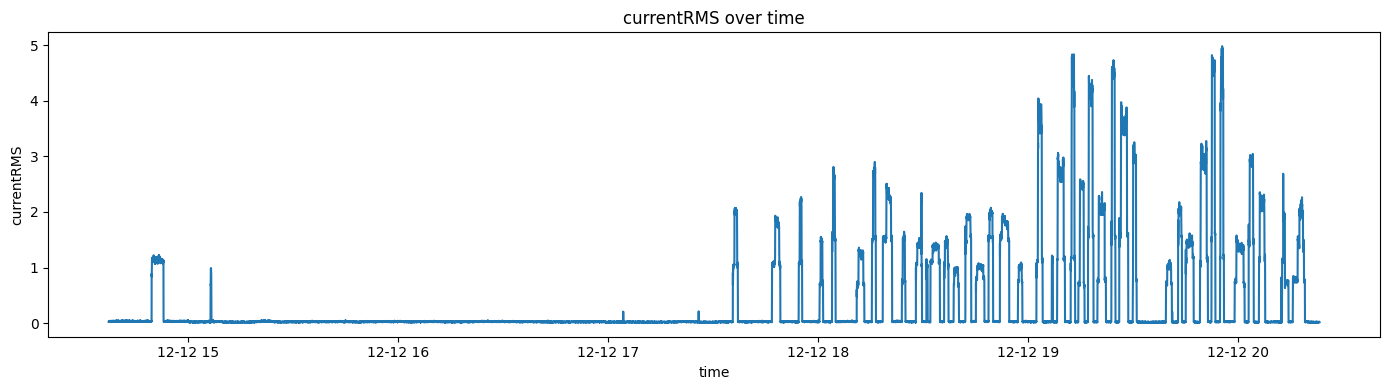


=== 2) Scatter: feedRateActual vs currentRMS ===



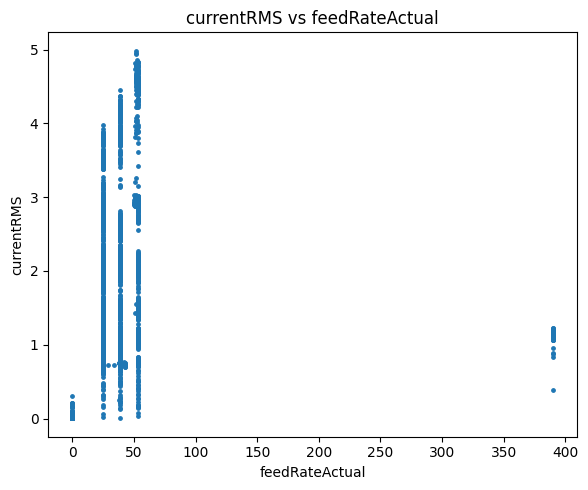


=== 3) Scatter: bandVelocityActual vs currentRMS ===



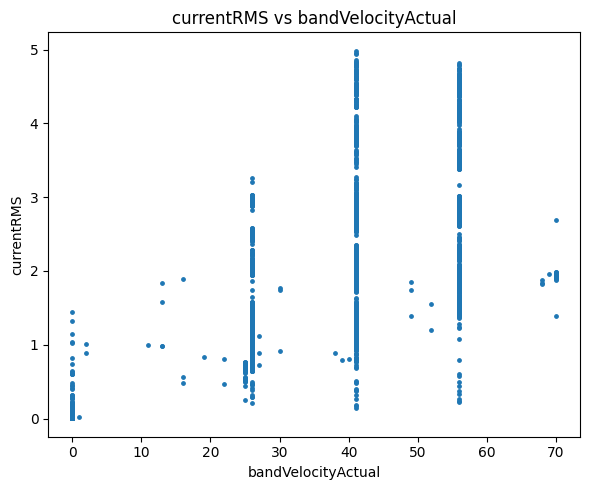


=== 4) Boxplots (binned X vs currentRMS) ===



/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[target].values for _, g in tmp.groupby("bin")]
/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = [str(k) for k, _ in tmp.groupby("bin")]


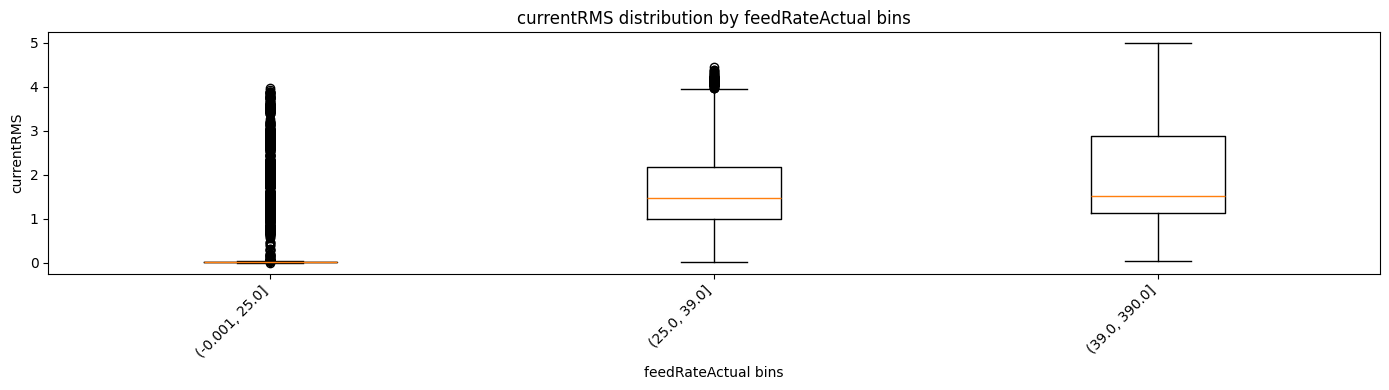

/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[target].values for _, g in tmp.groupby("bin")]
/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = [str(k) for k, _ in tmp.groupby("bin")]


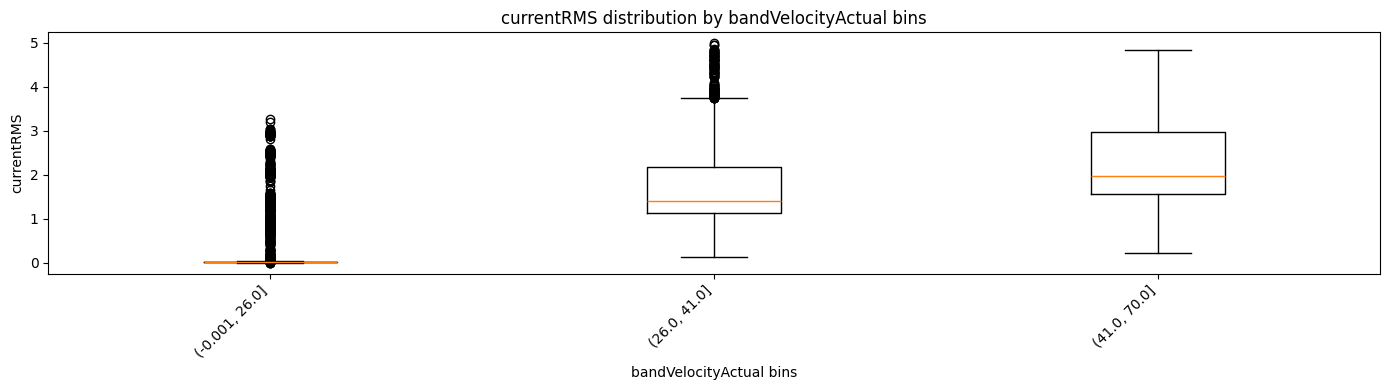

In [35]:
# --- columns ---
time_col = "time"
target = "currentRMS"
x1 = "feedRateActual"
x2 = "bandVelocityActual"

# --- preparation ---
df_plot = df[[time_col, target, x1, x2]].copy()
df_plot[time_col] = pd.to_datetime(df_plot[time_col], errors="coerce")

for c in [target, x1, x2]:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

df_plot = df_plot.dropna(subset=[time_col]).sort_values(time_col)


print("\n=== 1) Target distribution over time ===\n")

plt.figure(figsize=(14, 4))
plt.plot(df_plot[time_col], df_plot[target])
plt.title(f"{target} over time")
plt.xlabel("time")
plt.ylabel(target)
plt.tight_layout()
plt.show()

print("\n=== 2) Scatter: feedRateActual vs currentRMS ===\n") 

plt.figure(figsize=(6, 5))
mask = df_plot[[x1, target]].notna().all(axis=1)
plt.scatter(df_plot.loc[mask, x1], df_plot.loc[mask, target], s=6)
plt.title(f"{target} vs {x1}")
plt.xlabel(x1)
plt.ylabel(target)
plt.tight_layout()
plt.show()

print("\n=== 3) Scatter: bandVelocityActual vs currentRMS ===\n") 

plt.figure(figsize=(6, 5))
mask = df_plot[[x2, target]].notna().all(axis=1)
plt.scatter(df_plot.loc[mask, x2], df_plot.loc[mask, target], s=6)
plt.title(f"{target} vs {x2}")
plt.xlabel(x2)
plt.ylabel(target)
plt.tight_layout()
plt.show()

print("\n=== 4) Boxplots (binned X vs currentRMS) ===\n")

def boxplot_binned(x_col: str, bins: int = 10):
    tmp = df_plot[[x_col, target]].dropna()
    if tmp.empty:
        print(f"No data for {x_col}")
        return

    tmp["bin"] = pd.qcut(tmp[x_col], q=min(bins, tmp[x_col].nunique()), duplicates="drop")

    groups = [g[target].values for _, g in tmp.groupby("bin")]
    labels = [str(k) for k, _ in tmp.groupby("bin")]

    plt.figure(figsize=(14, 4))
    plt.boxplot(groups, showfliers=True)
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha="right")
    plt.title(f"{target} distribution by {x_col} bins")
    plt.xlabel(f"{x_col} bins")
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()


boxplot_binned(x1, bins=10)
boxplot_binned(x2, bins=10)


1.x. Experiments, performed on 12.12 in Smart Lab printed. 

In [38]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)            
pd.set_option("display.max_colwidth", None)    

df = pd.read_excel("Experiments Band Saw 12.12 simplified.xlsx")
print(df.to_string(index=False))

 Experiment No  Piece No Material Timestamp Start Timestamp End Time Diff  Material thickness (mm)  Feed Rate  Band Speed  Setup Code (for the machine operator) Avg Current         Result                                                                                                              Comments
             1         1    steel        18:36:05      18:36:57  00:00:52                     29.2         39          41                                      1         2.1         Success                                                                             Vibration Sensor moved closer to the saw
             2         1    steel        18:47:41      18:48:50  00:01:09                     29.2         25          41                                      2         1.8         Success                                                                                                                  NaN
             3         1    steel        18:54:43      18:55:17  00:00:34         

# 2. Experiments (?)

Try 1. Drop False values for machine running and keep the rest for datarobot.

In [3]:
in_file = "influxDB Backup/saw_wide.csv"
out_file = "influxDB Backup/saw_wide_maschineRunning_true.csv"

df = pd.read_csv(in_file)

# machineRunning can be bool, "True"/"False" strings, 1/0, or NaN
mr = df["machineRunning"]

mask_true = (
    (mr == True) |
    (mr.astype(str).str.strip().str.lower() == "true") |
    (pd.to_numeric(mr, errors="coerce") == 1)
)

df[mask_true].to_csv(out_file, index=False)

print(f"Saved {mask_true.sum()} rows to: {out_file}")

Saved 3741 rows to: influxDB Backup/saw_wide_maschineRunning_true.csv


Join of columns "experiment No", "Piece No" and "Material" to the dataset saw_wide_maschineRunning_true for time series identifecation

In [2]:
import pandas as pd

# paths
exp_path = "Experiments Band Saw 12.12 simplified.xlsx"
saw_path = "influxDB Backup/saw_wide_maschineRunning_true.csv"
out_path = "influxDB Backup/saw_wide_maschineRunning_true_joined.csv"

# load
exp = pd.read_excel(exp_path)
saw = pd.read_csv(saw_path)

# tidy column names
exp.columns = exp.columns.str.strip()
saw.columns = saw.columns.str.strip()

# parse saw time (full datetime)
saw["time"] = pd.to_datetime(saw["time"], errors="coerce")

# Excel has only HH:MM:SS -> take the date from saw file and attach it to experiment times
date_str = saw["time"].dropna().dt.normalize().min().strftime("%Y-%m-%d")
exp["Timestamp Start"] = pd.to_datetime(date_str + " " + exp["Timestamp Start"].astype(str), errors="coerce")
exp["Timestamp End"]   = pd.to_datetime(date_str + " " + exp["Timestamp End"].astype(str), errors="coerce")

# if end < start, assume experiment crosses midnight
m = exp["Timestamp End"] < exp["Timestamp Start"]
exp.loc[m, "Timestamp End"] += pd.Timedelta(days=1)

# sort for merge_asof
exp = exp.sort_values("Timestamp Start")
saw = saw.sort_values("time")

# interval labeling: assign each saw row the latest experiment start at/before its time
tmp = pd.merge_asof(
    saw,
    exp[["Timestamp Start", "Timestamp End", "Experiment No", "Piece No", "Material"]],
    left_on="time",
    right_on="Timestamp Start",
    direction="backward"
)

# keep metadata only if time is inside [start, end]
inside = (tmp["time"] >= tmp["Timestamp Start"]) & (tmp["time"] <= tmp["Timestamp End"])

# fill for non-matching rows
tmp.loc[~inside, ["Experiment No", "Piece No"]] = -1
tmp.loc[~inside, "Material"] = "Empty"

# ensure integer dtypes in final output
# (use to_numeric to be safe, then cast to int)
tmp["Experiment No"] = pd.to_numeric(tmp["Experiment No"], errors="coerce").fillna(-1).astype(int)
tmp["Piece No"]      = pd.to_numeric(tmp["Piece No"], errors="coerce").fillna(-1).astype(int)

# also force these saw columns to int (rounded/truncated via astype after numeric conversion)
for col in ["bandVelocityActual", "feedRateActual"]:
    if col in tmp.columns:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce").fillna(0).astype(int)

# drop helper columns and save
out = tmp.drop(columns=["Timestamp Start", "Timestamp End"])
out.to_csv(out_path, index=False)

out.head()


,time,bandVelocityActual,currentRMS,feedRateActual,machineRunning,microphoneRMS,temperatureRMS,vibrationRMS,Experiment No,Piece No,Material
0,2025-12-12 14:49:43,2,0.886779,390,True,0.074864,24.348553,3.503168,-1,-1,Empty
1,2025-12-12 14:49:44,41,0.838384,390,True,0.084009,24.357191,4.272558,-1,-1,Empty
2,2025-12-12 14:49:45,41,0.876621,390,True,0.086972,24.344240,3.908590,-1,-1,Empty
3,2025-12-12 14:49:46,41,0.960319,390,True,0.072588,24.345861,2.589309,-1,-1,Empty
4,2025-12-12 14:49:47,41,1.120628,390,True,0.082789,24.327732,2.690249,-1,-1,Empty
